# Template for hand-in on private clustering

Advanced Topics in Machine Learning, U. Copenhagen, fall 2023

Created by Rasmus Pagh

# Fetch and load dataset

The dataset consists of 3414 embedding vectors for first names from the GloVe dataset. Each vector is a 100-dimensional unit vector.

In [63]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

!curl -s https://rasmuspagh.net/data/glove.twitter.27B.100d.names.pickle -O
input_file = "glove.twitter.27B.100d.names.pickle"
with open(input_file, 'rb') as f:
    embedding = pickle.load(f)
names = list(embedding.keys())
points = np.array([ embedding[x] for x in names ])
n, d = points.shape



# Non-private implementation of cost computation and k-means algorithm

In [64]:
def compute_cost(points, centers):
    distances_squared = np.sum((points - centers[:, np.newaxis])**2, axis=-1)
    return np.mean(np.min(distances_squared, axis=0))

# Placeholder: Function for private_k_means (this is already modified in the notebook)
def private_k_means(points, k, t, rho):
    n, d = points.shape
    initial_assignment = np.random.choice(range(k), n)
    cluster_indexes = [ (initial_assignment == i) for i in range(k) ]
    cluster_sizes = [ cluster_indexes[i].sum() for i in range(k) ]

    # Calculate sigma and sigma_prime based on rho
    sigma = np.sqrt(2 * t / rho)
    sigma_prime = np.sqrt(t / rho)

    for l in range(t):
        # Compute noisy cluster sums and noisy centers
        cluster_sums = [ np.sum(points[cluster_indexes[i]], axis=0) + np.random.normal(0, sigma, size=d) for i in range(k) ]
        centers = np.array([ cluster_sums[i] / max(1, cluster_sizes[i]) for i in range(k) ])

        # Compute distances and assign points to nearest cluster
        distances_squared = np.sum((points - centers[:, np.newaxis])**2, axis=-1)
        assignment = np.argmin(distances_squared, axis=0)

        # Update cluster indexes and sizes with noise
        cluster_indexes = [ (assignment == i) for i in range(k) ]
        cluster_sizes = [ cluster_indexes[i].sum() + np.random.normal(0, sigma_prime) for i in range(k) ]

    return centers

# Plot cost as function of number of iterations

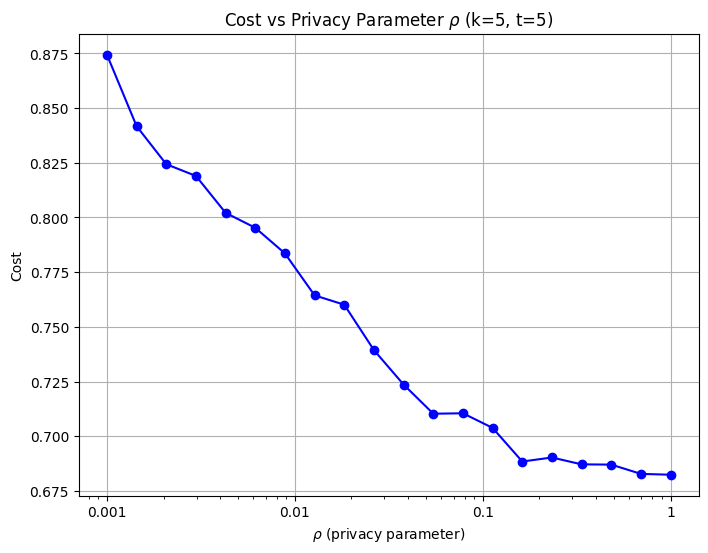

Minimum cost: 0.6824 at ρ = 1.0000
Maximum cost: 0.8744 at ρ = 0.0010


In [66]:
# Main execution
k = 5
t = 5

# Generating logarithmically spaced rho values
rho_values = np.logspace(-3, 0, 20)


costs = []
for rho in rho_values:
    centers = private_k_means(points, k, t, rho)
    costs.append(compute_cost(points, centers))

# Correcting the LaTeX formatting for the plot title
plt.figure(figsize=(8, 6))
plt.plot(rho_values, costs, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xticks([0.001, 0.01, 0.1, 1], [0.001, 0.01, 0.1, 1])
plt.xlabel(r'$\rho$ (privacy parameter)')
plt.ylabel('Cost')
plt.title(r'Cost vs Privacy Parameter $\rho$ (k=5, t=5)')
plt.grid(True)

# Display the plot
plt.show()

# Printing some statistics
print(f"Minimum cost: {min(costs):.4f} at ρ = {rho_values[np.argmin(costs)]:.4f}")
print(f"Maximum cost: {max(costs):.4f} at ρ = {rho_values[np.argmax(costs)]:.4f}")